# Objective : - Applying Logistic Regression on Amazon Fine Food Reviews

In [2]:
# Importing libraries
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer

import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

# Loading Data

In [3]:
# using the SQLite Table to read data.
con1 = sqlite3.connect('database.sqlite')

# Eliminating neutral reviews i.e. those reviews with Score = 3
filtered_data = pd.read_sql_query(" SELECT * FROM Reviews WHERE Score != 3 ", con1)

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def polarity(x):
    if x < 3:
        return 'negative'
    return 'positive'

# Applying polarity function on Score column of filtered_data
filtered_data['Score'] = filtered_data['Score'].map(polarity)

print(filtered_data.shape)
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Data Cleaning: Deduplication

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print(final.shape)

#Checking to see how much % of data still remains
((final.shape[0]*1.0)/(filtered_data.shape[0]*1.0)*100)

(364173, 10)


69.25890143662969

In [5]:
# Removing rows where HelpfulnessNumerator is greater than HelpfulnessDenominator
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

print(final.shape)
final[30:50]

(364171, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
138676,150493,0006641040,AMX0PJKV4PPNJ,"E. R. Bird ""Ramseelbird""",71,72,positive,1096416000,Read it once. Read it twice. Reading Chicken S...,"These days, when a person says, ""chicken soup""..."
138682,150500,0006641040,A1IJKK6Q1GTEAY,A Customer,2,2,positive,1009324800,It Was a favorite!,This was a favorite book of mine when I was a ...
138681,150499,0006641040,A3E7R866M94L0C,"L. Barker ""simienwolf""",2,2,positive,1065830400,Can't explain why,This book has been a favorite of mine since I ...
476617,515426,141278509X,AB1A5EGHHVA9M,CHelmic,1,1,positive,1332547200,The best drink mix,This product by Archer Farms is the best drink...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,positive,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,negative,1192060800,made in china,My dogs loves this chicken but its a product f...
284375,308077,2841233731,A3QD68O22M2XHQ,LABRNTH,0,0,positive,1345852800,Great recipe book for my babycook,This book is easy to read and the ingredients ...
157850,171161,7310172001,AFXMWPNS1BLU4,H. Sandler,0,0,positive,1229385600,Excellent treats,I have been feeding my greyhounds these treats...
157849,171160,7310172001,A74C7IARQEM1R,stucker,0,0,positive,1230076800,Sophie's Treats,This is one product that my welsh terrier can ...


OBSERVATION :- Here books with ProductId - 0006641040 and 2841233731 are also there so we have to remove all these rows with these ProductIds from the data

In [6]:
final = final[final['ProductId'] != '2841233731']
final = final[final['ProductId'] != '0006641040']
final.shape

(364136, 10)

# Text Preprocessing: Stemming, stop-word removal and Lemmatization.

In [7]:
#set of stopwords in English
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
words_to_keep = set(('not'))
stop -= words_to_keep
#initialising the snowball stemmer
sno = nltk.stem.SnowballStemmer('english')

 #function to clean the word of any html-tags
def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

#function to clean the word of any punctuation or special characters
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [8]:
#Code for removing HTML tags , punctuations . Code for removing stopwords . Code for checking if word is not alphanumeric and
# also greater than 2 . Code for stemmimg and also to convert them to lowercase letters 
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    
    final_string.append(str1)
    i+=1

In [9]:
#adding a column of CleanedText which displays the data after pre-processing of the review
final['CleanedText']=final_string  
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
#below the processed review can be seen in the CleanedText Column 
print('Shape of final',final.shape)
final.head()

Shape of final (364136, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
476617,515426,141278509X,AB1A5EGHHVA9M,CHelmic,1,1,positive,1332547200,The best drink mix,This product by Archer Farms is the best drink...,product archer farm best drink mix ever mix fl...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,positive,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dog love saw pet store tag attach regard made ...
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,negative,1192060800,made in china,My dogs loves this chicken but its a product f...,dog love chicken product china wont buy anymor...
157850,171161,7310172001,AFXMWPNS1BLU4,H. Sandler,0,0,positive,1229385600,Excellent treats,I have been feeding my greyhounds these treats...,feed greyhound treat year hound littl finicki ...
157849,171160,7310172001,A74C7IARQEM1R,stucker,0,0,positive,1230076800,Sophie's Treats,This is one product that my welsh terrier can ...,one product welsh terrier eat sophi food alerg...


TIME BASED SPLITTING OF SAMPLE DATASET

In [10]:
from sklearn.model_selection import train_test_split
##Sorting data according to Time in ascending order for Time Based Splitting
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

x = time_sorted_data['CleanedText'].values
y = time_sorted_data['Score']

# split the data set into train and test
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=0)

# (1). Bag of Words (BoW)

In [11]:
#BoW
count_vect = CountVectorizer(min_df = 50) 
X_train_vec = count_vect.fit_transform(X_train)
X_test_vec = count_vect.transform(X_test)
print("the type of count vectorizer :",type(X_train_vec))
print("the shape of out text BOW vectorizer : ",X_train_vec.get_shape())
print("the number of unique words :", X_train_vec.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer :  (254895, 6098)
the number of unique words : 6098


In [12]:
import warnings
warnings.filterwarnings('ignore')
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X_train_vec_standardized = sc.fit_transform(X_train_vec)
X_test_vec_standardized = sc.transform(X_test_vec)

# (1.a) L2 Regularisation (Logistic Regression)

In [13]:
# Importing libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# GridSearchCV Implementation

In [14]:
# Importing libraries for accuracy metrics
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score

tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, scoring = 'accuracy', cv=3 ,n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

Model with best parameters :
 LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of the model :  0.9220347671661738
The optimal value of C(1/lambda) is :  0.01


In [15]:
# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized,Y_train)
predictions = lr.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
bow_l2_grid_C = optimal_C
bow_l2_grid_train_acc = model.score(X_test_vec_standardized, Y_test)*100
bow_l2_grid_test_acc = accuracy_score(Y_test, predictions) * 100

In [16]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 'positive') 
print('\nThe Test Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test F1-Score of the Logistic regression classifier for C = %.3f is %f' % (optimal_C, acc))


The Test Accuracy of the Logistic Regression classifier for C = 0.010 is 92.203477%

The Test Precision of the Logistic Regression classifier for C = 0.010 is 0.939562

The Test Recall of the Logistic Regression classifier for C = 0.010 is 0.970006

The Test F1-Score of the Logistic regression classifier for C = 0.010 is 0.954541


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

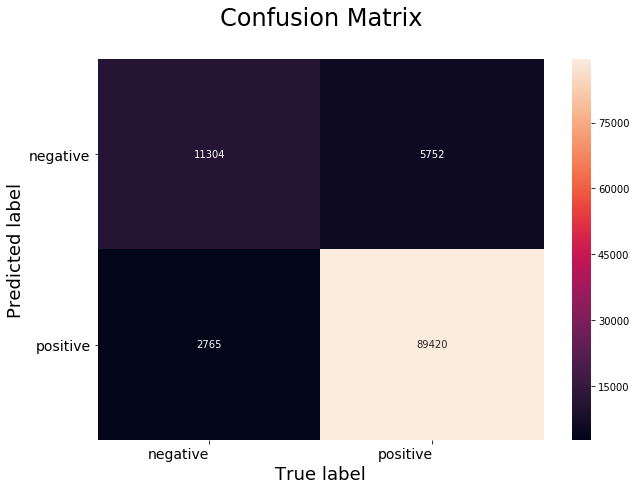

In [17]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

MULTI-COLLINEARITY CHECK (PERTUBATION TECHNIQUE):

In [18]:
import scipy as sp
epsilon = sp.stats.distributions.norm.rvs(loc=0,scale=0.0001)
# Vector before the addition of epsilon
W_before_epsilon = lr.coef_

# Number of non zero elements in X_train_vec_standardized sparse matrix
no_of_non_zero = X_train_vec_standardized.count_nonzero()

# Importing library to create a sparse matrix of epsilon
from scipy.sparse import csr_matrix

# Creating new sparse matrix with epsilon at same position of non-zero elements of X_train_vec_standardized
indices_X_train = X_train_vec_standardized.indices
indptr_X_train = X_train_vec_standardized.indptr

# Creating a list of same element with repetition
data = [epsilon] * no_of_non_zero
Shape = X_train_vec_standardized.shape

# Creating sparse matrix
sparse_epsilon = csr_matrix((data,indices_X_train,indptr_X_train),shape=Shape,dtype=float)

# Add sparse_epsilon and X-train_vec_standardized to get a new sparse matrix with epsilon added to each 
# non-zero element of X_train_vec_standardized
epsilon_train = X_train_vec_standardized + sparse_epsilon

print(X_train_vec_standardized.shape)
print(epsilon_train.shape)

(254895, 6098)
(254895, 6098)


In [20]:
# training Logistic Regression Classifier with epsilon_train
epsilon_lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
epsilon_lr.fit(epsilon_train,Y_train)

# Vector after the addition of epsilon
W_after_epsilon = epsilon_lr.coef_

# Change in vectors after adding epsilon
change_vector = W_after_epsilon - W_before_epsilon

# Sort this change_vector array after making all the elements positive in ascending order to visualize the change
sorted_change_vector = np.sort(np.absolute(change_vector))[:,::-1]

sorted_change_vector[0,0:20]

array([0.00159401, 0.0015377 , 0.0007778 , 0.00070106, 0.00067028,
       0.00058177, 0.00053523, 0.00046506, 0.00038904, 0.00038481,
       0.0003417 , 0.00030557, 0.00029905, 0.0002522 , 0.00024272,
       0.00023424, 0.00021348, 0.00020301, 0.0002027 , 0.00020228])

OBSERVATION :- From above we can see that there is no large change in the weights of the both vectors . So we will use absolute value of weights(|w|) of the feature to find important features

# Selecting Top 20 Important Features Using Absolute Value of Weights (|w|)

In [21]:
absolute_weights = np.absolute(W_before_epsilon)
sorted_absolute_index = np.argsort(absolute_weights)[:,::-1]
top_index = sorted_absolute_index[0,0:20]

all_features = count_vect.get_feature_names()
weight_values = lr.coef_

# Top 20 features are    
print("Top 20 features with their weight values :")

for j in top_index:
    print("%12s\t--> \t%f"%(all_features[j],weight_values[0,j]))

Top 20 features with their weight values :
       great	--> 	0.730310
        love	--> 	0.529931
        best	--> 	0.522764
      delici	--> 	0.505242
     perfect	--> 	0.424769
        good	--> 	0.412219
       excel	--> 	0.361000
  disappoint	--> 	-0.346830
        nice	--> 	0.308957
     favorit	--> 	0.271029
        amaz	--> 	0.268661
       worst	--> 	-0.238738
      awesom	--> 	0.233476
        easi	--> 	0.229080
       tasti	--> 	0.227755
      wonder	--> 	0.222639
       happi	--> 	0.220394
        tast	--> 	-0.216859
        find	--> 	0.207083
     terribl	--> 	-0.206875


# RandomizedSearchCV Implementation

In [22]:
# Load libraries
from scipy.stats import uniform

# Create regularization hyperparameter distribution using uniform distribution
C = uniform(loc=0, scale=10)

# Create hyperparameter options
hyperparameters = dict(C=C)

#Using RandomizedSearchCV
model = RandomizedSearchCV(LogisticRegression(penalty='l2'), hyperparameters, scoring='accuracy', cv=3,n_jobs=-1,pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized,Y_train)
predictions = lr.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
bow_l2_random_C = optimal_C
bow_l2_random_train_acc = model.score(X_test_vec_standardized, Y_test)*100
bow_l2_random_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=1.4275875917132186, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy of the model :  0.9219798427330398
The optimal value of C(1/lambda) is :  1.4275875917132186


In [23]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %f is %f%%' % (optimal_C, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 'positive') 
print('\nThe Test Precision of the Logistic Regression classifier for C = %f is %f' % (optimal_C, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test Recall of the Logistic Regression classifier for C = %f is %f' % (optimal_C, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test F1-Score of the Logistic regression classifier for C = %f is %f' % (optimal_C, acc))


The Test Accuracy of the Logistic Regression classifier for C = 1.427588 is 92.197984%

The Test Precision of the Logistic Regression classifier for C = 1.427588 is 0.939863

The Test Recall of the Logistic Regression classifier for C = 1.427588 is 0.969583

The Test F1-Score of the Logistic regression classifier for C = 1.427588 is 0.954492


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

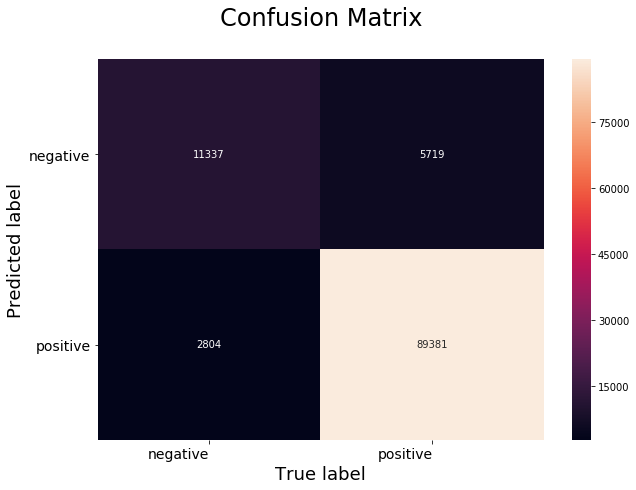

In [24]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

MULTI-COLLINEARITY CHECK (PERTUBATION TECHNIQUE):

In [25]:
epsilon = sp.stats.distributions.norm.rvs(loc=0,scale=0.0001)
# Vector before the addition of epsilon
W_before_epsilon = lr.coef_
# Number of non zero elements in X_train_vec_standardized sparse matrix
no_of_non_zero = X_train_vec_standardized.count_nonzero()

# Creating new sparse matrix with epsilon at same position of non-zero elements of X_train_vec_standardized
indices_X_train = X_train_vec_standardized.indices
indptr_X_train = X_train_vec_standardized.indptr

# Creating a list of same element with repetition
data = [epsilon] * no_of_non_zero
Shape = X_train_vec_standardized.shape

# Creating sparse matrix
sparse_epsilon = csr_matrix((data,indices_X_train,indptr_X_train),shape=Shape,dtype=float)

# Add sparse_epsilon and X-train_vec_standardized to get a new sparse matrix with epsilon added to each 
# non-zero element of X_train_vec_standardized
epsilon_train = X_train_vec_standardized + sparse_epsilon

# training Logistic Regression Classifier with epsilon_train
epsilon_lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
epsilon_lr.fit(epsilon_train,Y_train)

# Vector after the addition of epsilon
W_after_epsilon = epsilon_lr.coef_

# Change in vectors after adding epsilon
change_vector = W_after_epsilon - W_before_epsilon
# Sort this change_vector array after making all the elements positive in ascending order to visualize the change
sorted_change_vector = np.sort(np.absolute(change_vector))[:,::-1]

sorted_change_vector[0,0:20]

array([3.05209910e-03, 1.25906345e-03, 1.23313482e-03, 1.21377331e-03,
       1.09612039e-03, 1.02361241e-03, 8.56108561e-04, 8.35524152e-04,
       8.03491894e-04, 7.62642014e-04, 6.86882235e-04, 6.66070131e-04,
       4.38079401e-04, 2.89659297e-04, 2.86900927e-04, 1.02420820e-04,
       9.55668323e-05, 9.24656867e-05, 9.18820166e-05, 7.80115213e-05])

OBSERVATION :- From above we can see that there is no large change in the weights of the both vectors . So we will use absolute value of weights(|w|) of the feature to find important features

# Selecting Top 20 Important Features Using Absolute Value of Weights (|w|)

In [26]:
absolute_weights = np.absolute(W_before_epsilon)
sorted_absolute_index = np.argsort(absolute_weights)[:,::-1]
top_index = sorted_absolute_index[0,0:20]

all_features = count_vect.get_feature_names()
weight_values = lr.coef_

# Top 20 features are    
print("Top 20 features with their weight values :")

for j in top_index:
    print("%12s\t--> \t%f"%(all_features[j],weight_values[0,j]))

Top 20 features with their weight values :
       great	--> 	0.749685
        love	--> 	0.540823
        best	--> 	0.538182
      delici	--> 	0.523692
     perfect	--> 	0.441224
        good	--> 	0.421720
       excel	--> 	0.372815
  disappoint	--> 	-0.352933
        nice	--> 	0.317290
        muir	--> 	0.301052
        moka	--> 	0.278407
        amaz	--> 	0.278136
     favorit	--> 	0.277408
        glen	--> 	-0.262062
       worst	--> 	-0.243421
      awesom	--> 	0.241359
         nom	--> 	0.239984
        easi	--> 	0.234943
       tasti	--> 	0.232444
      wonder	--> 	0.228119


# (1.b) L1 Regularisation (Logistic regression)

# GridSearchCV Implementation

In [27]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring = 'accuracy', cv=3 ,n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l1', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized,Y_train)
predictions = lr.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
bow_l1_grid_C = optimal_C
bow_l1_grid_train_acc = model.score(X_test_vec_standardized, Y_test)*100
bow_l1_grid_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of the model :  0.9224558544868685
The optimal value of C(1/lambda) is :  0.01


In [28]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 'positive') 
print('\nThe Test Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test F1-Score of the Logistic regression classifier for C = %.3f is %f' % (optimal_C, acc))


The Test Accuracy of the Logistic Regression classifier for C = 0.010 is 92.247416%

The Test Precision of the Logistic Regression classifier for C = 0.010 is 0.934590

The Test Recall of the Logistic Regression classifier for C = 0.010 is 0.976471

The Test F1-Score of the Logistic regression classifier for C = 0.010 is 0.955072


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

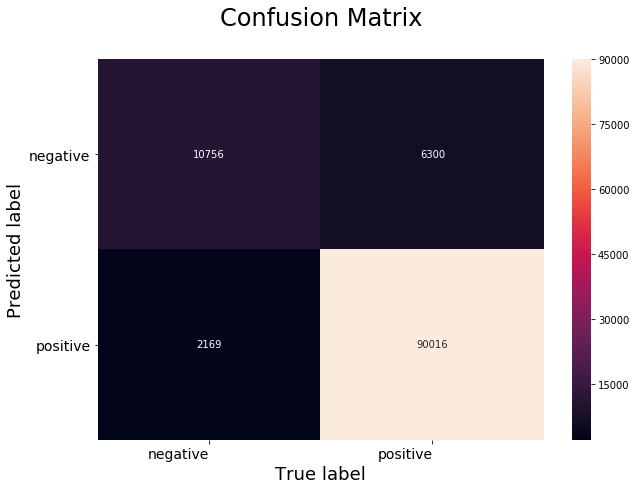

In [29]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

MULTI-COLLINEARITY CHECK (PERTUBATION TECHNIQUE):

In [31]:
epsilon = sp.stats.distributions.norm.rvs(loc=0,scale=0.0001)
# Vector before the addition of epsilon
W_before_epsilon = lr.coef_
# Number of non zero elements in X_train_vec_standardized sparse matrix
no_of_non_zero = X_train_vec_standardized.count_nonzero()

# Creating new sparse matrix with epsilon at same position of non-zero elements of X_train_vec_standardized
indices_X_train = X_train_vec_standardized.indices
indptr_X_train = X_train_vec_standardized.indptr

# Creating a list of same element with repetition
data = [epsilon] * no_of_non_zero
Shape = X_train_vec_standardized.shape

# Creating sparse matrix
sparse_epsilon = csr_matrix((data,indices_X_train,indptr_X_train),shape=Shape,dtype=float)

# Add sparse_epsilon and X-train_vec_standardized to get a new sparse matrix with epsilon added to each 
# non-zero element of X_train_vec_standardized
epsilon_train = X_train_vec_standardized + sparse_epsilon

# training Logistic Regression Classifier with epsilon_train
epsilon_lr = LogisticRegression(penalty='l1', C=optimal_C, n_jobs=-1)
epsilon_lr.fit(epsilon_train,Y_train)

# Vector after the addition of epsilon
W_after_epsilon = epsilon_lr.coef_

# Change in vectors after adding epsilon
change_vector = W_after_epsilon - W_before_epsilon
# Sort this change_vector array after making all the elements positive in ascending order to visualize the change
sorted_change_vector = np.sort(np.absolute(change_vector))[:,::-1]

sorted_change_vector[0,0:20]

array([0.00579108, 0.00568539, 0.00039819, 0.00030376, 0.0002599 ,
       0.00022093, 0.00016221, 0.00016142, 0.00015442, 0.00015005,
       0.00014986, 0.0001476 , 0.00012443, 0.00011613, 0.0001115 ,
       0.00010834, 0.0001061 , 0.00010378, 0.00010375, 0.00010074])

OBSERVATION :- From above we can see that there is no large change in the weights of the both vectors . So we will use absolute value of weights(|w|) of the feature to find important features

# Selecting Top 20 Important Features Using Absolute Value of Weights (|w|)

In [32]:
absolute_weights = np.absolute(W_before_epsilon)
sorted_absolute_index = np.argsort(absolute_weights)[:,::-1]
top_index = sorted_absolute_index[0,0:20]

all_features = count_vect.get_feature_names()
weight_values = lr.coef_

# Top 20 features are    
print("Top 20 features with their weight values :")

for j in top_index:
    print("%12s\t--> \t%f"%(all_features[j],weight_values[0,j]))

Top 20 features with their weight values :
       great	--> 	0.671857
        love	--> 	0.484587
        best	--> 	0.471564
      delici	--> 	0.451778
     perfect	--> 	0.373985
        good	--> 	0.358111
       excel	--> 	0.322410
  disappoint	--> 	-0.315437
        nice	--> 	0.272810
     favorit	--> 	0.242436
        amaz	--> 	0.227471
       worst	--> 	-0.214513
        easi	--> 	0.203188
       tasti	--> 	0.200469
      awesom	--> 	0.199951
       happi	--> 	0.193542
      wonder	--> 	0.189211
        tast	--> 	-0.188332
      return	--> 	-0.184318
       thank	--> 	0.183874


# More Sparsity (Fewer elements of W* being non-zero) by increasing Lambda (decreasing C)

In [33]:
# With lambda = 1
clf = LogisticRegression(C=1, penalty='l1',n_jobs=-1);
clf.fit(X_train_vec_standardized, Y_train);
w = clf.coef_
print(np.count_nonzero(w))

6068


In [34]:
# With lambda = 10
clf = LogisticRegression(C=0.1, penalty='l1',n_jobs=-1);
clf.fit(X_train_vec_standardized, Y_train);
w = clf.coef_
print(np.count_nonzero(w))

5815


In [35]:
# With lambda = 100
clf = LogisticRegression(C=0.01, penalty='l1',n_jobs=-1);
clf.fit(X_train_vec_standardized, Y_train);
w = clf.coef_
print(np.count_nonzero(w))

3674


In [36]:
# With lambda = 1000
clf = LogisticRegression(C=0.001, penalty='l1',n_jobs=-1);
clf.fit(X_train_vec_standardized, Y_train);
w = clf.coef_
print(np.count_nonzero(w))

381


OBSERVATION :- From above we can see that the number of non-zero elements of W* is decreasing as we are increasing the value of lambda (C is decreasing) .

# RandomizedSearchCV Implementation

In [37]:
# Create regularization hyperparameter distribution using uniform distribution
C = uniform(loc=0, scale=10)

# Create hyperparameter options
hyperparameters = dict(C=C)

#Using RandomizedSearchCV
model = RandomizedSearchCV(LogisticRegression(penalty='l1'), hyperparameters, scoring='accuracy', cv=3,n_jobs=-1,pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l1', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized,Y_train)
predictions = lr.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
bow_l1_random_C = optimal_C
bow_l1_random_train_acc = model.score(X_test_vec_standardized, Y_test)*100
bow_l1_random_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=0.20062843367622873, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy of the model :  0.9222361567543321
The optimal value of C(1/lambda) is :  0.20062843367622873


In [38]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 'positive') 
print('\nThe Test Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test F1-Score of the Logistic regression classifier for C = %.3f is %f' % (optimal_C, acc))


The Test Accuracy of the Logistic Regression classifier for C = 0.201 is 92.226362%

The Test Precision of the Logistic Regression classifier for C = 0.201 is 0.939661

The Test Recall of the Logistic Regression classifier for C = 0.201 is 0.970180

The Test F1-Score of the Logistic regression classifier for C = 0.201 is 0.954676


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

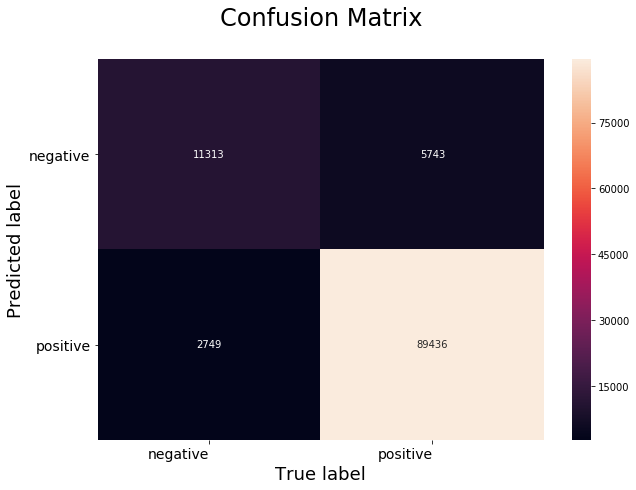

In [39]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

MULTI-COLLINEARITY CHECK (PERTUBATION TECHNIQUE):

In [40]:
epsilon = sp.stats.distributions.norm.rvs(loc=0,scale=0.0001)
# Vector before the addition of epsilon
W_before_epsilon = lr.coef_
# Number of non zero elements in X_train_vec_standardized sparse matrix
no_of_non_zero = X_train_vec_standardized.count_nonzero()

# Creating new sparse matrix with epsilon at same position of non-zero elements of X_train_vec_standardized
indices_X_train = X_train_vec_standardized.indices
indptr_X_train = X_train_vec_standardized.indptr

# Creating a list of same element with repetition
data = [epsilon] * no_of_non_zero
Shape = X_train_vec_standardized.shape

# Creating sparse matrix
sparse_epsilon = csr_matrix((data,indices_X_train,indptr_X_train),shape=Shape,dtype=float)

# Add sparse_epsilon and X-train_vec_standardized to get a new sparse matrix with epsilon added to each 
# non-zero element of X_train_vec_standardized
epsilon_train = X_train_vec_standardized + sparse_epsilon

# training Logistic Regression Classifier with epsilon_train
epsilon_lr = LogisticRegression(penalty='l1', C=optimal_C, n_jobs=-1)
epsilon_lr.fit(epsilon_train,Y_train)

# Vector after the addition of epsilon
W_after_epsilon = epsilon_lr.coef_

# Change in vectors after adding epsilon
change_vector = W_after_epsilon - W_before_epsilon
# Sort this change_vector array after making all the elements positive in ascending order to visualize the change
sorted_change_vector = np.sort(np.absolute(change_vector))[:,::-1]

sorted_change_vector[0,0:20]

array([0.02237764, 0.02158832, 0.00169514, 0.00167163, 0.00088758,
       0.00088361, 0.00069944, 0.0006367 , 0.00063072, 0.00061668,
       0.00056487, 0.00054095, 0.00048238, 0.00043977, 0.00043314,
       0.00036974, 0.00036678, 0.00032307, 0.00028503, 0.00027125])

OBSERVATION :- From above we can see that there is no large change in the weights of the both vectors . So we will use absolute value of weights(|w|) of the feature to find important features

# Selecting Top 20 Important Features Using Absolute Value of Weights (|w|)

In [41]:
absolute_weights = np.absolute(W_before_epsilon)
sorted_absolute_index = np.argsort(absolute_weights)[:,::-1]
top_index = sorted_absolute_index[0,0:20]

all_features = count_vect.get_feature_names()
weight_values = lr.coef_

# Top 20 features are    
print("Top 20 features with their weight values :")

for j in top_index:
    print("%12s\t--> \t%f"%(all_features[j],weight_values[0,j]))

Top 20 features with their weight values :
       great	--> 	0.742383
        love	--> 	0.535755
        best	--> 	0.532161
      delici	--> 	0.517292
     perfect	--> 	0.435130
        good	--> 	0.416290
       excel	--> 	0.368052
  disappoint	--> 	-0.349331
        nice	--> 	0.313458
     favorit	--> 	0.274382
        amaz	--> 	0.273673
       worst	--> 	-0.240574
      awesom	--> 	0.237796
        easi	--> 	0.232143
       tasti	--> 	0.229744
      wonder	--> 	0.224586
       happi	--> 	0.222856
        tast	--> 	-0.222744
       yummi	--> 	0.209360
        find	--> 	0.208743


# (2) TFIDF

In [42]:
tf_idf_vect = TfidfVectorizer(min_df=50)
X_train_vec = tf_idf_vect.fit_transform(X_train)
X_test_vec = tf_idf_vect.transform(X_test)
print("the type of count vectorizer :",type(X_train_vec))
print("the shape of out text TFIDF vectorizer : ",X_train_vec.get_shape())
print("the number of unique words :", X_train_vec.get_shape()[1])

# Data-preprocessing: Standardizing the data
sc = StandardScaler(with_mean=False)
X_train_vec_standardized = sc.fit_transform(X_train_vec)
X_test_vec_standardized = sc.transform(X_test_vec)

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (254895, 6098)
the number of unique words : 6098


# (2.a) L2 Regularisation (Logistic Regression)

# GridSearchCV Implementation

In [43]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, scoring = 'accuracy', cv=3 ,n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized,Y_train)
predictions = lr.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_l2_grid_C = optimal_C
tfidf_l2_grid_train_acc = model.score(X_test_vec_standardized, Y_test)*100
tfidf_l2_grid_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of the model :  0.9245704451625305
The optimal value of C(1/lambda) is :  0.01


In [44]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 'positive') 
print('\nThe Test Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test F1-Score of the Logistic regression classifier for C = %.3f is %f' % (optimal_C, acc))


The Test Accuracy of the Logistic Regression classifier for C = 0.010 is 92.457045%

The Test Precision of the Logistic Regression classifier for C = 0.010 is 0.944318

The Test Recall of the Logistic Regression classifier for C = 0.010 is 0.967674

The Test F1-Score of the Logistic regression classifier for C = 0.010 is 0.955853


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

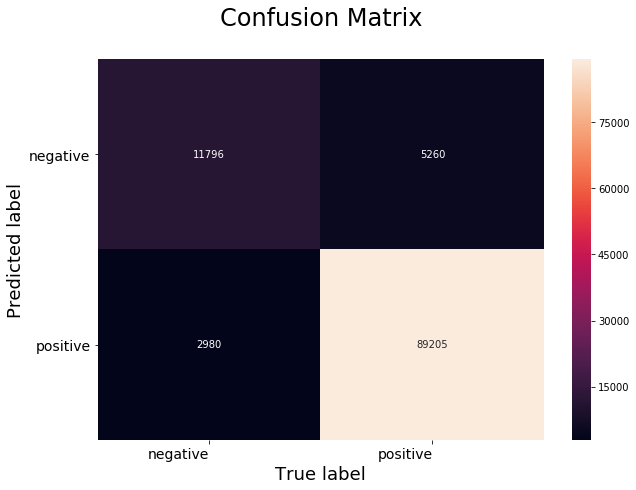

In [45]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

MULTI-COLLINEARITY CHECK (PERTUBATION TECHNIQUE):

In [46]:
epsilon = sp.stats.distributions.norm.rvs(loc=0,scale=0.0001)
# Vector before the addition of epsilon
W_before_epsilon = lr.coef_
# Number of non zero elements in X_train_vec_standardized sparse matrix
no_of_non_zero = X_train_vec_standardized.count_nonzero()

# Creating new sparse matrix with epsilon at same position of non-zero elements of X_train_vec_standardized
indices_X_train = X_train_vec_standardized.indices
indptr_X_train = X_train_vec_standardized.indptr

# Creating a list of same element with repetition
data = [epsilon] * no_of_non_zero
Shape = X_train_vec_standardized.shape

# Creating sparse matrix
sparse_epsilon = csr_matrix((data,indices_X_train,indptr_X_train),shape=Shape,dtype=float)

# Add sparse_epsilon and X-train_vec_standardized to get a new sparse matrix with epsilon added to each 
# non-zero element of X_train_vec_standardized
epsilon_train = X_train_vec_standardized + sparse_epsilon

# training Logistic Regression Classifier with epsilon_train
epsilon_lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
epsilon_lr.fit(epsilon_train,Y_train)

# Vector after the addition of epsilon
W_after_epsilon = epsilon_lr.coef_

# Change in vectors after adding epsilon
change_vector = W_after_epsilon - W_before_epsilon
# Sort this change_vector array after making all the elements positive in ascending order to visualize the change
sorted_change_vector = np.sort(np.absolute(change_vector))[:,::-1]

sorted_change_vector[0,0:20]

array([2.04264368e-04, 1.98353779e-04, 9.67404104e-05, 8.41218957e-05,
       6.98817831e-05, 5.89690569e-05, 5.87498048e-05, 5.43898704e-05,
       5.35128423e-05, 5.23590224e-05, 5.15183141e-05, 4.98570144e-05,
       4.33669317e-05, 3.83531952e-05, 3.71385635e-05, 3.71200760e-05,
       3.56373557e-05, 3.54688122e-05, 3.26788083e-05, 3.21656309e-05])

OBSERVATION :- From above we can see that there is no large change in the weights of the both vectors . So we will use absolute value of weights(|w|) of the feature to find important features

# Selecting Top 20 Important Features Using Absolute Value of Weights (|w|)

In [47]:
absolute_weights = np.absolute(W_before_epsilon)
sorted_absolute_index = np.argsort(absolute_weights)[:,::-1]
top_index = sorted_absolute_index[0,0:20]

all_features = tf_idf_vect.get_feature_names()
weight_values = lr.coef_

# Top 20 features are    
print("Top 20 features with their weight values :")

for j in top_index:
    print("%12s\t--> \t%f"%(all_features[j],weight_values[0,j]))

Top 20 features with their weight values :
       great	--> 	0.824989
        love	--> 	0.590899
        best	--> 	0.565669
      delici	--> 	0.538336
     perfect	--> 	0.443156
        good	--> 	0.424295
       excel	--> 	0.393403
  disappoint	--> 	-0.305526
        nice	--> 	0.302383
     favorit	--> 	0.292604
        amaz	--> 	0.270344
      awesom	--> 	0.256720
        easi	--> 	0.241699
       worst	--> 	-0.237943
      wonder	--> 	0.232105
       yummi	--> 	0.230961
       tasti	--> 	0.221280
       thank	--> 	0.219595
        find	--> 	0.215802
     fantast	--> 	0.213699


# RandomizedSearchCV Implementation

In [48]:
# Create regularization hyperparameter distribution using uniform distribution
C = uniform(loc=0, scale=10)

# Create hyperparameter options
hyperparameters = dict(C=C)

#Using RandomizedSearchCV
model = RandomizedSearchCV(LogisticRegression(penalty='l2'), hyperparameters, scoring='accuracy', cv=3,n_jobs=-1,pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized,Y_train)
predictions = lr.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_l2_random_C = optimal_C
tfidf_l2_random_train_acc = model.score(X_test_vec_standardized, Y_test)*100
tfidf_l2_random_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=4.827593247007973, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy of the model :  0.9243782096465613
The optimal value of C(1/lambda) is :  4.827593247007973


In [49]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %f is %f%%' % (optimal_C, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 'positive') 
print('\nThe Test Precision of the Logistic Regression classifier for C = %f is %f' % (optimal_C, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test Recall of the Logistic Regression classifier for C = %f is %f' % (optimal_C, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test F1-Score of the Logistic regression classifier for C = %f is %f' % (optimal_C, acc))


The Test Accuracy of the Logistic Regression classifier for C = 4.827593 is 92.437821%

The Test Precision of the Logistic Regression classifier for C = 4.827593 is 0.944268

The Test Recall of the Logistic Regression classifier for C = 4.827593 is 0.967489

The Test F1-Score of the Logistic regression classifier for C = 4.827593 is 0.955738


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

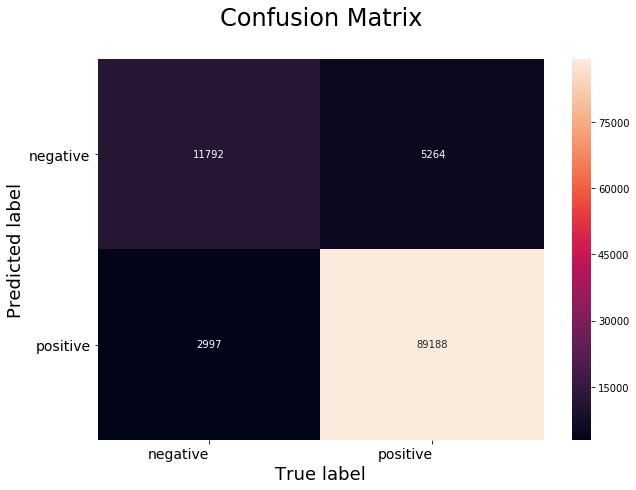

In [50]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

MULTI-COLLINEARITY CHECK (PERTUBATION TECHNIQUE):

In [51]:
epsilon = sp.stats.distributions.norm.rvs(loc=0,scale=0.0001)
# Vector before the addition of epsilon
W_before_epsilon = lr.coef_
# Number of non zero elements in X_train_vec_standardized sparse matrix
no_of_non_zero = X_train_vec_standardized.count_nonzero()

# Creating new sparse matrix with epsilon at same position of non-zero elements of X_train_vec_standardized
indices_X_train = X_train_vec_standardized.indices
indptr_X_train = X_train_vec_standardized.indptr

# Creating a list of same element with repetition
data = [epsilon] * no_of_non_zero
Shape = X_train_vec_standardized.shape

# Creating sparse matrix
sparse_epsilon = csr_matrix((data,indices_X_train,indptr_X_train),shape=Shape,dtype=float)

# Add sparse_epsilon and X-train_vec_standardized to get a new sparse matrix with epsilon added to each 
# non-zero element of X_train_vec_standardized
epsilon_train = X_train_vec_standardized + sparse_epsilon

# training Logistic Regression Classifier with epsilon_train
epsilon_lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
epsilon_lr.fit(epsilon_train,Y_train)

# Vector after the addition of epsilon
W_after_epsilon = epsilon_lr.coef_

# Change in vectors after adding epsilon
change_vector = W_after_epsilon - W_before_epsilon
# Sort this change_vector array after making all the elements positive in ascending order to visualize the change
sorted_change_vector = np.sort(np.absolute(change_vector))[:,::-1]

sorted_change_vector[0,0:20]

array([8.87431952e-05, 6.30367082e-05, 6.29254718e-05, 6.27161106e-05,
       5.62670654e-05, 5.57362672e-05, 5.50217821e-05, 4.55021679e-05,
       4.46283845e-05, 4.28031537e-05, 4.24521546e-05, 4.19164487e-05,
       3.98683431e-05, 3.97135763e-05, 3.31797616e-05, 2.51553410e-05,
       1.91065413e-05, 1.75863252e-05, 1.72318094e-05, 1.69828696e-05])

OBSERVATION :- From above we can see that there is no large change in the weights of the both vectors . So we will use absolute value of weights(|w|) of the feature to find important features

# Selecting Top 20 Important Features Using Absolute Value of Weights (|w|)

In [52]:
absolute_weights = np.absolute(W_before_epsilon)
sorted_absolute_index = np.argsort(absolute_weights)[:,::-1]
top_index = sorted_absolute_index[0,0:20]

all_features = tf_idf_vect.get_feature_names()
weight_values = lr.coef_

# Top 20 features are    
print("Top 20 features with their weight values :")

for j in top_index:
    print("%12s\t--> \t%f"%(all_features[j],weight_values[0,j]))

Top 20 features with their weight values :
       great	--> 	0.850204
        love	--> 	0.603318
        best	--> 	0.583994
      delici	--> 	0.560556
     perfect	--> 	0.462133
        good	--> 	0.431604
       excel	--> 	0.407692
  disappoint	--> 	-0.311574
        nice	--> 	0.310207
     favorit	--> 	0.299839
        amaz	--> 	0.279799
      awesom	--> 	0.266254
        easi	--> 	0.248024
       worst	--> 	-0.242299
       yummi	--> 	0.239338
      wonder	--> 	0.237348
       tasti	--> 	0.224943
       thank	--> 	0.223960
     fantast	--> 	0.221815
      addict	--> 	0.220521


# (2.b) L1 Regularisation (Logistic regression)

# GridSearchCV Implementation

In [53]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring = 'accuracy', cv=3 ,n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l1', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized,Y_train)
predictions = lr.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_l1_grid_C = optimal_C
tfidf_l1_grid_train_acc = model.score(X_test_vec_standardized, Y_test)*100
tfidf_l1_grid_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of the model :  0.9258886315577485
The optimal value of C(1/lambda) is :  0.01


In [54]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %f is %f%%' % (optimal_C, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 'positive') 
print('\nThe Test Precision of the Logistic Regression classifier for C = %f is %f' % (optimal_C, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test Recall of the Logistic Regression classifier for C = %f is %f' % (optimal_C, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test F1-Score of the Logistic regression classifier for C = %f is %f' % (optimal_C, acc))


The Test Accuracy of the Logistic Regression classifier for C = 0.010000 is 92.589779%

The Test Precision of the Logistic Regression classifier for C = 0.010000 is 0.941001

The Test Recall of the Logistic Regression classifier for C = 0.010000 is 0.973206

The Test F1-Score of the Logistic regression classifier for C = 0.010000 is 0.956832


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

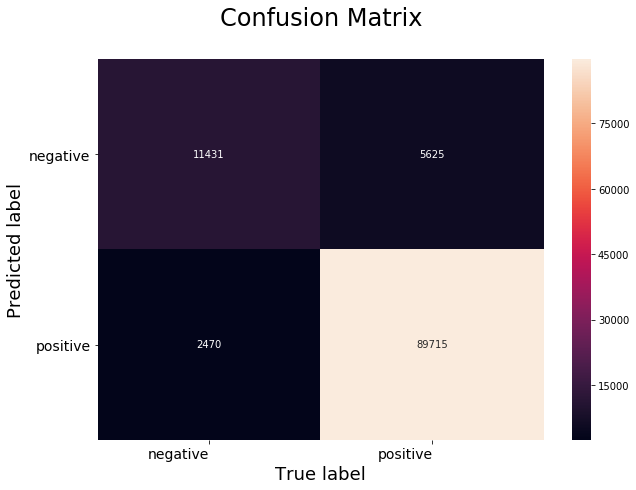

In [55]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

MULTI-COLLINEARITY CHECK (PERTUBATION TECHNIQUE):

In [56]:
epsilon = sp.stats.distributions.norm.rvs(loc=0,scale=0.0001)
# Vector before the addition of epsilon
W_before_epsilon = lr.coef_
# Number of non zero elements in X_train_vec_standardized sparse matrix
no_of_non_zero = X_train_vec_standardized.count_nonzero()

# Creating new sparse matrix with epsilon at same position of non-zero elements of X_train_vec_standardized
indices_X_train = X_train_vec_standardized.indices
indptr_X_train = X_train_vec_standardized.indptr

# Creating a list of same element with repetition
data = [epsilon] * no_of_non_zero
Shape = X_train_vec_standardized.shape

# Creating sparse matrix
sparse_epsilon = csr_matrix((data,indices_X_train,indptr_X_train),shape=Shape,dtype=float)

# Add sparse_epsilon and X-train_vec_standardized to get a new sparse matrix with epsilon added to each 
# non-zero element of X_train_vec_standardized
epsilon_train = X_train_vec_standardized + sparse_epsilon

# training Logistic Regression Classifier with epsilon_train
epsilon_lr = LogisticRegression(penalty='l1', C=optimal_C, n_jobs=-1)
epsilon_lr.fit(epsilon_train,Y_train)

# Vector after the addition of epsilon
W_after_epsilon = epsilon_lr.coef_

# Change in vectors after adding epsilon
change_vector = W_after_epsilon - W_before_epsilon
# Sort this change_vector array after making all the elements positive in ascending order to visualize the change
sorted_change_vector = np.sort(np.absolute(change_vector))[:,::-1]

sorted_change_vector[0,0:20]

array([2.21733505e-04, 1.82563302e-04, 1.73249691e-04, 1.62491182e-04,
       1.28155685e-04, 1.12210395e-04, 1.07174428e-04, 1.01721274e-04,
       8.56302666e-05, 8.09102511e-05, 7.95781859e-05, 7.94541525e-05,
       7.84000199e-05, 7.78564244e-05, 6.79457968e-05, 6.73540266e-05,
       6.67539489e-05, 6.43223632e-05, 6.41916587e-05, 6.34377651e-05])

OBSERVATION :- From above we can see that there is no large change in the weights of the both vectors . So we will use absolute value of weights(|w|) of the feature to find important features

# Selecting Top 20 Important Features Using Absolute Value of Weights (|w|)

In [57]:
absolute_weights = np.absolute(W_before_epsilon)
sorted_absolute_index = np.argsort(absolute_weights)[:,::-1]
top_index = sorted_absolute_index[0,0:20]

all_features = tf_idf_vect.get_feature_names()
weight_values = lr.coef_

# Top 20 features are    
print("Top 20 features with their weight values :")

for j in top_index:
    print("%12s\t--> \t%f"%(all_features[j],weight_values[0,j]))

Top 20 features with their weight values :
       great	--> 	0.773984
        love	--> 	0.555771
        best	--> 	0.526791
      delici	--> 	0.496685
     perfect	--> 	0.408177
        good	--> 	0.385962
       excel	--> 	0.362690
  disappoint	--> 	-0.285032
        nice	--> 	0.276128
     favorit	--> 	0.268575
        amaz	--> 	0.239582
      awesom	--> 	0.223106
        easi	--> 	0.219676
       worst	--> 	-0.218179
      wonder	--> 	0.203090
       yummi	--> 	0.201855
       tasti	--> 	0.199293
        find	--> 	0.196676
       thank	--> 	0.195658
       happi	--> 	0.191244


# More Sparsity (Fewer elements of W* being non-zero) by increasing Lambda (decreasing C)

In [58]:
# With lambda = 1
clf = LogisticRegression(C=1, penalty='l1',n_jobs=-1);
clf.fit(X_train_vec_standardized, Y_train);
w = clf.coef_
print(np.count_nonzero(w))

6061


In [59]:
# With lambda = 10
clf = LogisticRegression(C=0.1, penalty='l1',n_jobs=-1);
clf.fit(X_train_vec_standardized, Y_train);
w = clf.coef_
print(np.count_nonzero(w))

5810


In [60]:
# With lambda = 100
clf = LogisticRegression(C=0.01, penalty='l1',n_jobs=-1);
clf.fit(X_train_vec_standardized, Y_train);
w = clf.coef_
print(np.count_nonzero(w))

3903


In [61]:
# With lambda = 1000
clf = LogisticRegression(C=0.001, penalty='l1',n_jobs=-1);
clf.fit(X_train_vec_standardized, Y_train);
w = clf.coef_
print(np.count_nonzero(w))

442


OBSERVATION :- From above we can see that the number of non-zero elements of W* is decreasing as we are increasing the value of lambda (C is decreasing) .

# RandomizedSearchCV Implementation

In [62]:
# Create regularization hyperparameter distribution using uniform distribution
C = uniform(loc=0, scale=10)

# Create hyperparameter options
hyperparameters = dict(C=C)

#Using RandomizedSearchCV
model = RandomizedSearchCV(LogisticRegression(penalty='l1'), hyperparameters, scoring='accuracy', cv=3,n_jobs=-1,pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l1', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized,Y_train)
predictions = lr.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_l1_random_C = optimal_C
tfidf_l1_random_train_acc = model.score(X_test_vec_standardized, Y_test)*100
tfidf_l1_random_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=0.8718584489029746, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy of the model :  0.9244697503684514
The optimal value of C(1/lambda) is :  0.8718584489029746


In [63]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %f is %f%%' % (optimal_C, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 'positive') 
print('\nThe Test Precision of the Logistic Regression classifier for C = %f is %f' % (optimal_C, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test Recall of the Logistic Regression classifier for C = %f is %f' % (optimal_C, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test F1-Score of the Logistic regression classifier for C = %f is %f' % (optimal_C, acc))


The Test Accuracy of the Logistic Regression classifier for C = 0.871858 is 92.447890%

The Test Precision of the Logistic Regression classifier for C = 0.871858 is 0.944303

The Test Recall of the Logistic Regression classifier for C = 0.871858 is 0.967576

The Test F1-Score of the Logistic regression classifier for C = 0.871858 is 0.955798


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

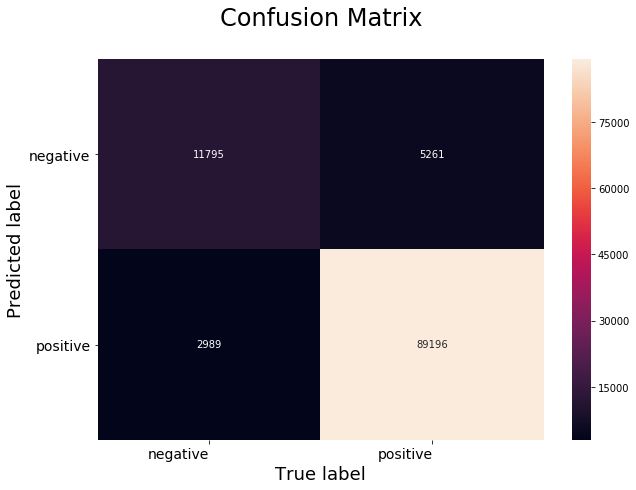

In [64]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

MULTI-COLLINEARITY CHECK (PERTUBATION TECHNIQUE):

In [65]:
epsilon = sp.stats.distributions.norm.rvs(loc=0,scale=0.0001)
# Vector before the addition of epsilon
W_before_epsilon = lr.coef_
# Number of non zero elements in X_train_vec_standardized sparse matrix
no_of_non_zero = X_train_vec_standardized.count_nonzero()

# Creating new sparse matrix with epsilon at same position of non-zero elements of X_train_vec_standardized
indices_X_train = X_train_vec_standardized.indices
indptr_X_train = X_train_vec_standardized.indptr

# Creating a list of same element with repetition
data = [epsilon] * no_of_non_zero
Shape = X_train_vec_standardized.shape

# Creating sparse matrix
sparse_epsilon = csr_matrix((data,indices_X_train,indptr_X_train),shape=Shape,dtype=float)

# Add sparse_epsilon and X-train_vec_standardized to get a new sparse matrix with epsilon added to each 
# non-zero element of X_train_vec_standardized
epsilon_train = X_train_vec_standardized + sparse_epsilon

# training Logistic Regression Classifier with epsilon_train
epsilon_lr = LogisticRegression(penalty='l1', C=optimal_C, n_jobs=-1)
epsilon_lr.fit(epsilon_train,Y_train)

# Vector after the addition of epsilon
W_after_epsilon = epsilon_lr.coef_

# Change in vectors after adding epsilon
change_vector = W_after_epsilon - W_before_epsilon
# Sort this change_vector array after making all the elements positive in ascending order to visualize the change
sorted_change_vector = np.sort(np.absolute(change_vector))[:,::-1]

sorted_change_vector[0,0:20]

array([0.00244115, 0.00241197, 0.00206425, 0.00173659, 0.00162052,
       0.00140127, 0.00135811, 0.00114338, 0.00103279, 0.00064469,
       0.00062623, 0.00062007, 0.00015853, 0.00014514, 0.00014103,
       0.00012394, 0.00012128, 0.00010544, 0.00010494, 0.00010258])

OBSERVATION :- From above we can see that there is no large change in the weights of the both vectors . So we will use absolute value of weights(|w|) of the feature to find important features

# Selecting Top 20 Important Features Using Absolute Value of Weights (|w|)

In [66]:
absolute_weights = np.absolute(W_before_epsilon)
sorted_absolute_index = np.argsort(absolute_weights)[:,::-1]
top_index = sorted_absolute_index[0,0:20]

all_features = tf_idf_vect.get_feature_names()
weight_values = lr.coef_

# Top 20 features are    
print("Top 20 features with their weight values :")

for j in top_index:
    print("%12s\t--> \t%f"%(all_features[j],weight_values[0,j]))

Top 20 features with their weight values :
       great	--> 	0.849038
        love	--> 	0.602777
        best	--> 	0.583035
      delici	--> 	0.559510
     perfect	--> 	0.461114
        good	--> 	0.431090
       excel	--> 	0.406908
  disappoint	--> 	-0.310883
        nice	--> 	0.309608
     favorit	--> 	0.299218
        amaz	--> 	0.278982
      awesom	--> 	0.265530
        easi	--> 	0.247506
       worst	--> 	-0.241804
       yummi	--> 	0.238737
      wonder	--> 	0.236777
       tasti	--> 	0.224669
       thank	--> 	0.223515
     fantast	--> 	0.221172
      addict	--> 	0.219877


# Word2Vec

In [67]:
# List of sentence in X_train text
sent_of_train=[]
for sent in X_train:
    sent_of_train.append(sent.split())

# List of sentence in X_est text
sent_of_test=[]
for sent in X_test:
    sent_of_test.append(sent.split())   
    
# Train your own Word2Vec model using your own train text corpus 
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(sent_of_train,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))

number of words that occured minimum 5 times  18825


# (3). Avg Word2Vec

In [68]:
# compute average word2vec for each review for X_train .
train_vectors = []; 
for sent in sent_of_train:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
    
# compute average word2vec for each review for X_test .
test_vectors = []; 
for sent in sent_of_test:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec) 

# Data-preprocessing: Standardizing the data
sc = StandardScaler()
X_train_vec_standardized = sc.fit_transform(train_vectors)
X_test_vec_standardized = sc.transform(test_vectors)    

# (3.a) L2 Regularisation (Logistic Regression)

# GridSearchCV Implementation

In [69]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, scoring = 'accuracy', cv=3 ,n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized,Y_train)
predictions = lr.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
avg_w2v_l2_grid_C = optimal_C
avg_w2v_l2_grid_train_acc = model.score(X_test_vec_standardized, Y_test)*100
avg_w2v_l2_grid_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of the model :  0.8996805228806034
The optimal value of C(1/lambda) is :  100


In [70]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 'positive') 
print('\nThe Test Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test F1-Score of the Logistic regression classifier for C = %.3f is %f' % (optimal_C, acc))


The Test Accuracy of the Logistic Regression classifier for C = 100.000 is 89.968052%

The Test Precision of the Logistic Regression classifier for C = 100.000 is 0.917228

The Test Recall of the Logistic Regression classifier for C = 100.000 is 0.968520

The Test F1-Score of the Logistic regression classifier for C = 100.000 is 0.942176


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

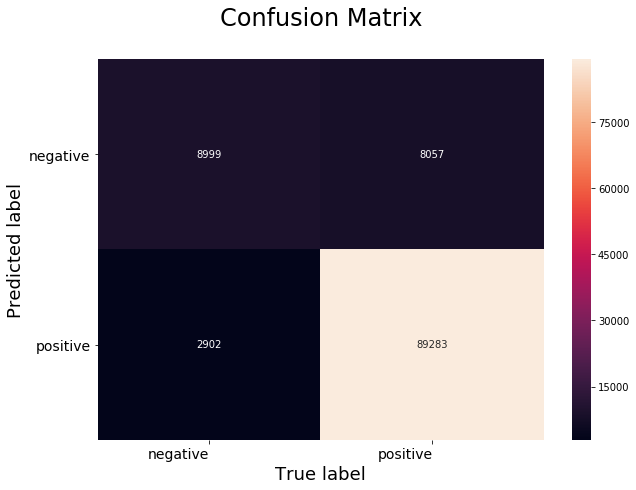

In [71]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

NOTE :- Here we can find out important features but they are not related to any words so they are not interpretable . I am not performing Multicollinearity Check and also not finding important features because they are not interpretable and hence it is irrelevant to find important features .

# RandomizedSearchCV Implementation

In [72]:
# Create regularization hyperparameter distribution using uniform distribution
C = uniform(loc=0, scale=10)

# Create hyperparameter options
hyperparameters = dict(C=C)

#Using RandomizedSearchCV
model = RandomizedSearchCV(LogisticRegression(penalty='l2'), hyperparameters, scoring='accuracy', cv=3,n_jobs=-1,pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized,Y_train)
predictions = lr.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
avg_w2v_l2_random_C = optimal_C
avg_w2v_l2_random_train_acc = model.score(X_test_vec_standardized, Y_test)*100
avg_w2v_l2_random_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=3.4697855417732635, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy of the model :  0.8996805228806034
The optimal value of C(1/lambda) is :  3.4697855417732635


In [73]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 'positive') 
print('\nThe Test Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test F1-Score of the Logistic regression classifier for C = %.3f is %f' % (optimal_C, acc))


The Test Accuracy of the Logistic Regression classifier for C = 3.470 is 89.968052%

The Test Precision of the Logistic Regression classifier for C = 3.470 is 0.917228

The Test Recall of the Logistic Regression classifier for C = 3.470 is 0.968520

The Test F1-Score of the Logistic regression classifier for C = 3.470 is 0.942176


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

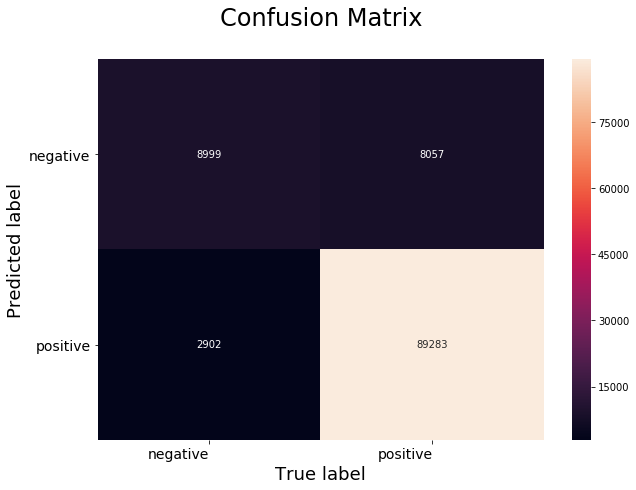

In [74]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

NOTE :- Here we can find out important features but they are not related to any words so they are not interpretable . I am not performing Multicollinearity Check and also not finding important features because they are not interpretable and hence it is irrelevant to find important features .

# (3.b) L1 Regularisation (Logistic Regression)

# GridSearchCV Implementation

In [75]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring = 'accuracy', cv=3 ,n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l1', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized,Y_train)
predictions = lr.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
avg_w2v_l1_grid_C = optimal_C
avg_w2v_l1_grid_train_acc = model.score(X_test_vec_standardized, Y_test)*100
avg_w2v_l1_grid_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of the model :  0.8996713688084145
The optimal value of C(1/lambda) is :  10000


In [76]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 'positive') 
print('\nThe Test Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test F1-Score of the Logistic regression classifier for C = %.3f is %f' % (optimal_C, acc))


The Test Accuracy of the Logistic Regression classifier for C = 10000.000 is 89.968052%

The Test Precision of the Logistic Regression classifier for C = 10000.000 is 0.917228

The Test Recall of the Logistic Regression classifier for C = 10000.000 is 0.968520

The Test F1-Score of the Logistic regression classifier for C = 10000.000 is 0.942176


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

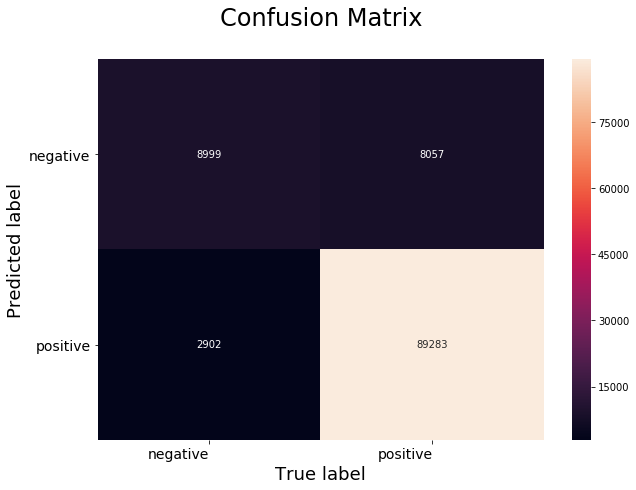

In [77]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

NOTE :- Here we can find out important features but they are not related to any words so they are not interpretable . I am not performing Multicollinearity Check and also not finding important features because they are not interpretable and hence it is irrelevant to find important features .

# More Sparsity (Fewer elements of W* being non-zero) by increasing Lambda (decreasing C)

In [78]:
# With lambda = 1
clf = LogisticRegression(C=1, penalty='l1',n_jobs=-1);
clf.fit(X_train_vec_standardized, Y_train);
w = clf.coef_
print(np.count_nonzero(w))

50


In [79]:
# With lambda = 10
clf = LogisticRegression(C=0.1, penalty='l1',n_jobs=-1);
clf.fit(X_train_vec_standardized, Y_train);
w = clf.coef_
print(np.count_nonzero(w))

50


In [80]:
# With lambda = 100
clf = LogisticRegression(C=0.01, penalty='l1',n_jobs=-1);
clf.fit(X_train_vec_standardized, Y_train);
w = clf.coef_
print(np.count_nonzero(w))

47


In [81]:
# With lambda = 1000
clf = LogisticRegression(C=0.001, penalty='l1',n_jobs=-1);
clf.fit(X_train_vec_standardized, Y_train);
w = clf.coef_
print(np.count_nonzero(w))

40


In [82]:
# With lambda = 10000
clf = LogisticRegression(C=0.0001, penalty='l1',n_jobs=-1);
clf.fit(X_train_vec_standardized, Y_train);
w = clf.coef_
print(np.count_nonzero(w))

11


OBSERVATION :- From above we can see that the number of non-zero elements of W* is decreasing as we are increasing the value of lambda (C is decreasing) .

# RandomizedSearchCV Implementation

In [83]:
# Create regularization hyperparameter distribution using uniform distribution
C = uniform(loc=0, scale=10)

# Create hyperparameter options
hyperparameters = dict(C=C)

#Using RandomizedSearchCV
model = RandomizedSearchCV(LogisticRegression(penalty='l1'), hyperparameters, scoring='accuracy', cv=3,n_jobs=-1,pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l1', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized,Y_train)
predictions = lr.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
avg_w2v_l1_random_C = optimal_C
avg_w2v_l1_random_train_acc = model.score(X_test_vec_standardized, Y_test)*100
avg_w2v_l1_random_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=8.218180574199001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy of the model :  0.8996622147362254
The optimal value of C(1/lambda) is :  8.218180574199001


In [84]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 'positive') 
print('\nThe Test Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test F1-Score of the Logistic regression classifier for C = %.3f is %f' % (optimal_C, acc))


The Test Accuracy of the Logistic Regression classifier for C = 8.218 is 89.966221%

The Test Precision of the Logistic Regression classifier for C = 8.218 is 0.917218

The Test Recall of the Logistic Regression classifier for C = 8.218 is 0.968509

The Test F1-Score of the Logistic regression classifier for C = 8.218 is 0.942166


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

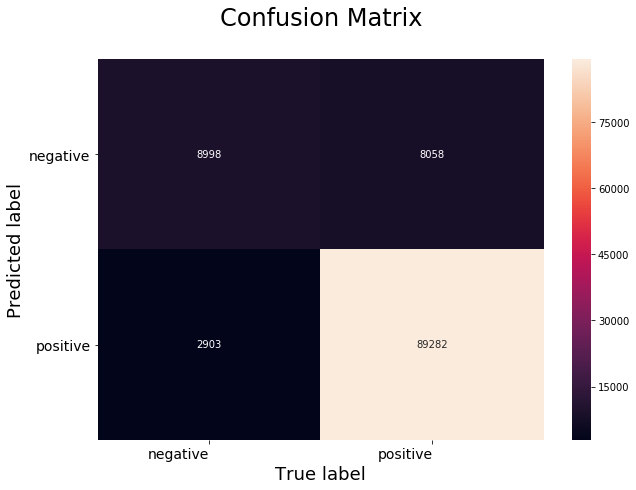

In [85]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

NOTE :- Here we can find out important features but they are not related to any words so they are not interpretable . I am not performing Multicollinearity Check and also not finding important features because they are not interpretable and hence it is irrelevant to find important features .

# (4). TFIDF-Word2Vec

NOTE :- It is taking a lot off time to perform TFIDF-Word2Vec on whole 364K rows of data . So , I am performing it with only 100K rows . Please don't mind because I am unable to perform it with whole data due to poor condition of my laptop . But I am completing all the steps as was asked .

RANDOMLY SAMPLING 100K POINTS OUT OF WHOLE DATASET

In [91]:
# We will collect different 100K rows without repetition from time_sorted_data dataframe
my_final = time_sorted_data.take(np.random.permutation(len(final))[:100000])
print(my_final.shape)

x = my_final['CleanedText'].values
y = my_final['Score']

# split the data set into train and test
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=0)

# List of sentence in X_train text
sent_of_train=[]
for sent in X_train:
    sent_of_train.append(sent.split())

# List of sentence in X_est text
sent_of_test=[]
for sent in X_test:
    sent_of_test.append(sent.split()) 
    
w2v_model=Word2Vec(sent_of_train,min_count=5,size=50, workers=4) 
w2v_words = list(w2v_model.wv.vocab)

(100000, 11)


In [92]:
# TF-IDF weighted Word2Vec
tf_idf_vect = TfidfVectorizer()

# final_tf_idf1 is the sparse matrix with row= sentence, col=word and cell_val = tfidf
final_tf_idf1 = tf_idf_vect.fit_transform(X_train)

# tfidf words/col-names
tfidf_feat = tf_idf_vect.get_feature_names()

# compute TFIDF Weighted Word2Vec for each review for X_test .
tfidf_test_vectors = []; 
row=0;
for sent in sent_of_test: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf1[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_test_vectors.append(sent_vec)
    row += 1 

In [93]:
# compute TFIDF Weighted Word2Vec for each review for X_train .
tfidf_train_vectors = []; 
row=0;
for sent in sent_of_train: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf1[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_train_vectors.append(sent_vec)
    row += 1  
    
# Data-preprocessing: Standardizing the data
sc = StandardScaler()
X_train_vec_standardized = sc.fit_transform(tfidf_train_vectors)
X_test_vec_standardized = sc.transform(tfidf_test_vectors)    

# (4.a) L2 Regularisation (Logistic Regression)

# GridSearchCV Implementation

In [94]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, scoring = 'accuracy', cv=3 ,n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized,Y_train)
predictions = lr.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_w2v_l2_grid_C = optimal_C
tfidf_w2v_l2_grid_train_acc = model.score(X_test_vec_standardized, Y_test)*100
tfidf_w2v_l2_grid_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of the model :  0.7401
The optimal value of C(1/lambda) is :  100


In [95]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 'positive') 
print('\nThe Test Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test F1-Score of the Logistic regression classifier for C = %.3f is %f' % (optimal_C, acc))


The Test Accuracy of the Logistic Regression classifier for C = 100.000 is 74.010000%

The Test Precision of the Logistic Regression classifier for C = 100.000 is 0.860084

The Test Recall of the Logistic Regression classifier for C = 100.000 is 0.826037

The Test F1-Score of the Logistic regression classifier for C = 100.000 is 0.842717


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

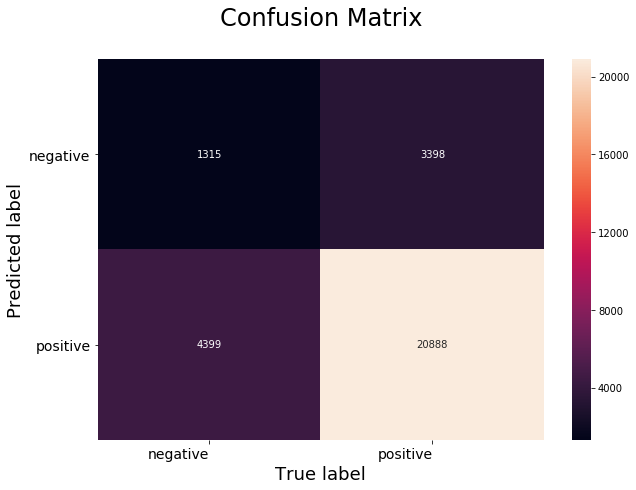

In [96]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

NOTE :- Here we can find out important features but they are not related to any words so they are not interpretable . I am not performing Multicollinearity Check and also not finding important features because they are not interpretable and hence it is irrelevant to find important features .

# RandomizedSearchCV Implementation

In [97]:
# Create regularization hyperparameter distribution using uniform distribution
C = uniform(loc=0, scale=10)

# Create hyperparameter options
hyperparameters = dict(C=C)

#Using RandomizedSearchCV
model = RandomizedSearchCV(LogisticRegression(penalty='l2'), hyperparameters, scoring='accuracy', cv=3,n_jobs=-1,pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l2', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized,Y_train)
predictions = lr.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_w2v_l2_random_C = optimal_C
tfidf_w2v_l2_random_train_acc = model.score(X_test_vec_standardized, Y_test)*100
tfidf_w2v_l2_random_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=4.63926046784341, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy of the model :  0.7401333333333333
The optimal value of C(1/lambda) is :  4.63926046784341


In [98]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 'positive') 
print('\nThe Test Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test F1-Score of the Logistic regression classifier for C = %.3f is %f' % (optimal_C, acc))


The Test Accuracy of the Logistic Regression classifier for C = 4.639 is 74.013333%

The Test Precision of the Logistic Regression classifier for C = 4.639 is 0.860090

The Test Recall of the Logistic Regression classifier for C = 4.639 is 0.826077

The Test F1-Score of the Logistic regression classifier for C = 4.639 is 0.842740


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

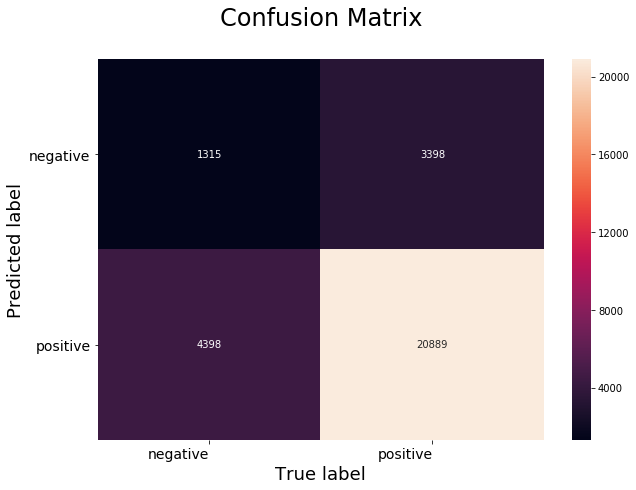

In [99]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

NOTE :- Here we can find out important features but they are not related to any words so they are not interpretable . I am not performing Multicollinearity Check and also not finding important features because they are not interpretable and hence it is irrelevant to find important features .

# (4.b) L1 Regularisation (Logistic Regression)

# GridSearchCV Implementation

In [100]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring = 'accuracy', cv=3 ,n_jobs=-1, pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l1', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized,Y_train)
predictions = lr.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_w2v_l1_grid_C = optimal_C
tfidf_w2v_l1_grid_train_acc = model.score(X_test_vec_standardized, Y_test)*100
tfidf_w2v_l1_grid_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy of the model :  0.7401333333333333
The optimal value of C(1/lambda) is :  100


In [101]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 'positive') 
print('\nThe Test Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test F1-Score of the Logistic regression classifier for C = %.3f is %f' % (optimal_C, acc))


The Test Accuracy of the Logistic Regression classifier for C = 100.000 is 74.013333%

The Test Precision of the Logistic Regression classifier for C = 100.000 is 0.860090

The Test Recall of the Logistic Regression classifier for C = 100.000 is 0.826077

The Test F1-Score of the Logistic regression classifier for C = 100.000 is 0.842740


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

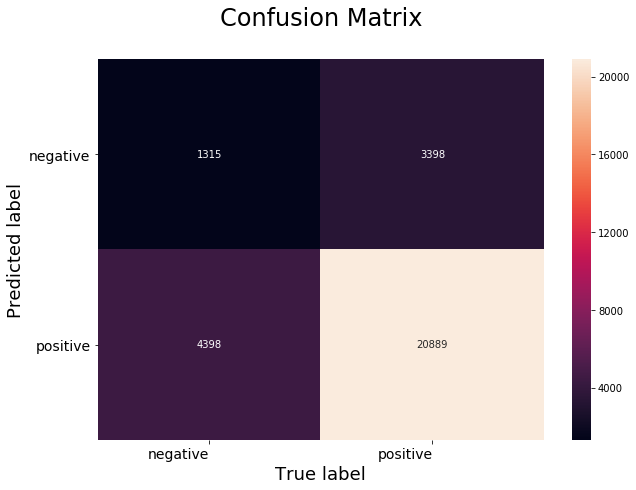

In [102]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

NOTE :- Here we can find out important features but they are not related to any words so they are not interpretable . I am not performing Multicollinearity Check and also not finding important features because they are not interpretable and hence it is irrelevant to find important features .

# More Sparsity (Fewer elements of W* being non-zero) by increasing Lambda (decreasing C)

In [103]:
# With lambda = 1
clf = LogisticRegression(C=1, penalty='l1',n_jobs=-1);
clf.fit(X_train_vec_standardized, Y_train);
w = clf.coef_
print(np.count_nonzero(w))

50


In [104]:
# With lambda = 10
clf = LogisticRegression(C=0.1, penalty='l1',n_jobs=-1);
clf.fit(X_train_vec_standardized, Y_train);
w = clf.coef_
print(np.count_nonzero(w))

50


In [105]:
# With lambda = 100
clf = LogisticRegression(C=0.01, penalty='l1',n_jobs=-1);
clf.fit(X_train_vec_standardized, Y_train);
w = clf.coef_
print(np.count_nonzero(w))

45


In [106]:
# With lambda = 1000
clf = LogisticRegression(C=0.001, penalty='l1',n_jobs=-1);
clf.fit(X_train_vec_standardized, Y_train);
w = clf.coef_
print(np.count_nonzero(w))

22


OBSERVATION :- From above we can see that the number of non-zero elements of W* is decreasing as we are increasing the value of lambda (C is decreasing) .

# RandomizedSearchCV Implementation

In [108]:
# Create regularization hyperparameter distribution using uniform distribution
C = uniform(loc=0, scale=10)

# Create hyperparameter options
hyperparameters = dict(C=C)

#Using RandomizedSearchCV
model = RandomizedSearchCV(LogisticRegression(penalty='l1'), hyperparameters, scoring='accuracy', cv=3,n_jobs=-1,pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_C = model.best_estimator_.C
print("The optimal value of C(1/lambda) is : ",optimal_C)

# Logistic Regression with Optimal value of C i.e.(1/lambda)
lr = LogisticRegression(penalty='l1', C=optimal_C, n_jobs=-1)
lr.fit(X_train_vec_standardized,Y_train)
predictions = lr.predict(X_test_vec_standardized)

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_w2v_l1_random_C = optimal_C
tfidf_w2v_l1_random_train_acc = model.score(X_test_vec_standardized, Y_test)*100
tfidf_w2v_l1_random_test_acc = accuracy_score(Y_test, predictions) * 100

Model with best parameters :
 LogisticRegression(C=8.837472691586914, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy of the model :  0.7401333333333333
The optimal value of C(1/lambda) is :  8.837472691586914


In [109]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the Logistic Regression classifier for C = %.3f is %f%%' % (optimal_C, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 'positive') 
print('\nThe Test Precision of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test Recall of the Logistic Regression classifier for C = %.3f is %f' % (optimal_C, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test F1-Score of the Logistic regression classifier for C = %.3f is %f' % (optimal_C, acc))


The Test Accuracy of the Logistic Regression classifier for C = 8.837 is 74.013333%

The Test Precision of the Logistic Regression classifier for C = 8.837 is 0.860060

The Test Recall of the Logistic Regression classifier for C = 8.837 is 0.826116

The Test F1-Score of the Logistic regression classifier for C = 8.837 is 0.842746


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

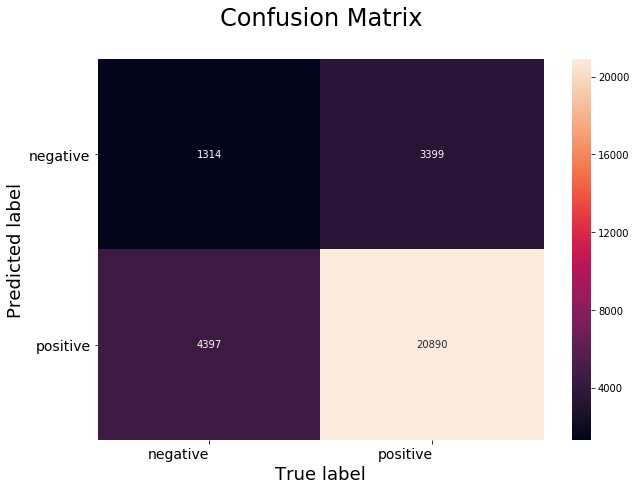

In [110]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

NOTE :- Here we can find out important features but they are not related to any words so they are not interpretable . I am not performing Multicollinearity Check and also not finding important features because they are not interpretable and hence it is irrelevant to find important features .

# CONCLUSION :-

# (a). Procedure followed :

STEP 1 :- Text Preprocessing

STEP 2:- Time-based splitting of whole dataset into train_data and test_data

STEP 3:- Training the vectorizer on train_data and later applying same vectorizer on both train_data and test_data to transform them into vectors

STEP 4:- Using Logistic regression as an estimator in both GridSearchCV and RandomizedSearchCV in order to find optimal value of C i.e(1/lambda) with both L1 and L2 regularisation

STEP 5:- Once , we get optimal value of C then train Logistic Regression (both L1 and L2 regularisation) again with this optimal C and make predictions on test_data

STEP 6 :- Evaluate : Accuracy , F1-Score , Precision , Recall 

STEP 7:- Draw Seaborn Heatmap for Confusion Matrix .

STEP 8:- Perform multicollinearity check and find important features (Only for BoW and TFIDF vectorizers)

STEP 9:- Creating more sparsity by increasing value of lambda i.e.(1/C) (Only for L1 regularisation)

Repeat from STEP 3 to STEP 9 for each of these two vectorizers : Bag Of Words(BoW), TFIDF 

Repeat from STEP 3 to STEP 9 (except STEP 8) for each of these two vectorizers :  Avg Word2Vec and TFIDF Word2Vec

# (b). Table (Model Performances with their hyperparameters :

In [114]:
# Creating table using PrettyTable library
from prettytable import PrettyTable

# Names of models
names = ['LR(l2|GridSearchCV) for BoW','LR(l2|RandomizedSearchCV) for BoW','LR(l1|GridSearchCV) for BoW',\
         'LR(l1|RandomizedSearchCV) for BoW','LR(l2|GridSearchCV) for TFIDF','LR(l2|RandomizedSearchCV) for TFIDF',\
         'LR(l1|GridSearchCV) for TFIDF','LR(l1|RandomizedSearchCV) for TFIDF','LR(l2|GridSearchCV) for Avg_Word2Vec',\
         'LR(l2|RandomizedSearchCV) for Avg_Word2Vec','LR(l1|GridSearchCV) for Avg_Word2Vec',\
         'LR(l1|RandomizedSearchCV) for Avg_Word2Vec','LR(l2|GridSearchCV) for tfidf_Word2Vec',\
         'LR(l2|RandomizedSearchCV) for tfidf_Word2Vec','LR(l1|GridSearchCV) for tfidf_Word2Vec',\
         'LR(l1|RandomizedSearchCV) for tfidf_Word2Vec']

# Optimal values of C i.e. (1/lambda)
optimal_C = [bow_l2_grid_C,bow_l2_random_C,bow_l1_grid_C,bow_l1_random_C,\
             tfidf_l2_grid_C,tfidf_l2_random_C,tfidf_l1_grid_C,tfidf_l1_random_C,\
             avg_w2v_l2_grid_C,avg_w2v_l2_random_C,avg_w2v_l1_grid_C,avg_w2v_l1_random_C,\
             tfidf_w2v_l2_grid_C,tfidf_w2v_l2_random_C,tfidf_w2v_l1_grid_C,tfidf_w2v_l1_random_C]

# Training accuracies
train_acc = [bow_l2_grid_train_acc,bow_l2_random_train_acc,bow_l1_grid_train_acc,bow_l1_random_train_acc,\
             tfidf_l2_grid_train_acc,tfidf_l2_random_train_acc,tfidf_l1_grid_train_acc,tfidf_l1_random_train_acc,\
             avg_w2v_l2_grid_train_acc,avg_w2v_l2_random_train_acc,avg_w2v_l1_grid_train_acc,avg_w2v_l1_random_train_acc,\
             tfidf_w2v_l2_grid_train_acc,tfidf_w2v_l2_random_train_acc,tfidf_w2v_l1_grid_train_acc,\
             tfidf_w2v_l1_random_train_acc]

# Test accuracies
test_acc = [bow_l2_grid_test_acc,bow_l2_random_test_acc,bow_l1_grid_test_acc,bow_l1_random_test_acc,\
             tfidf_l2_grid_test_acc,tfidf_l2_random_test_acc,tfidf_l1_grid_test_acc,tfidf_l1_random_test_acc,\
             avg_w2v_l2_grid_test_acc,avg_w2v_l2_random_test_acc,avg_w2v_l1_grid_test_acc,avg_w2v_l1_random_test_acc,\
             tfidf_w2v_l2_grid_test_acc,tfidf_w2v_l2_random_test_acc,tfidf_w2v_l1_grid_test_acc,tfidf_w2v_l1_random_test_acc]

numbering = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",names)
ptable.add_column("Best C(1/lambda)",optimal_C)
ptable.add_column("Training Accuracy",train_acc)
ptable.add_column("Test Accuracy",test_acc)


# Printing note regarding information of "MODEL" column in the table
print("NOTE:- In the Table below in 'MODEL' column :")
print("\t LR(l2|GridSearchCV) : Logistic Regression with L2 regularisation as an estimator in GridSearchCV")
print("\t LR(l1|GridSearchCV) : Logistic Regression with L1 regularisation as an estimator in GridSearchCV")
print("\t LR(l2|RandomizedSearchCV) : Logistic Regression with L2 regularisation as an estimator in RandomizedSearchCV")
print("\t LR(l1|RandomizedSearchCV) : Logistic Regression with L1 regularisation as an estimator in RandomizedSearchCV\n\n")
# Printing the Table
print(ptable)

NOTE:- In the Table below in 'MODEL' column :
	 LR(l2|GridSearchCV) : Logistic Regression with L2 regularisation as an estimator in GridSearchCV
	 LR(l1|GridSearchCV) : Logistic Regression with L1 regularisation as an estimator in GridSearchCV
	 LR(l2|RandomizedSearchCV) : Logistic Regression with L2 regularisation as an estimator in RandomizedSearchCV
	 LR(l1|RandomizedSearchCV) : Logistic Regression with L1 regularisation as an estimator in RandomizedSearchCV


+-------+----------------------------------------------+---------------------+-------------------+-------------------+
| S.NO. |                    MODEL                     |   Best C(1/lambda)  | Training Accuracy |   Test Accuracy   |
+-------+----------------------------------------------+---------------------+-------------------+-------------------+
|   1   |         LR(l2|GridSearchCV) for BoW          |         0.01        | 92.20347671661739 | 92.20347671661739 |
|   2   |      LR(l2|RandomizedSearchCV) for BoW       |